<a href="https://colab.research.google.com/github/BandaVallary/Movie_Recommendation_System/blob/kelvin/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

!["Image of Donald Draper in a Movie Theater"](https://github.com/BandaVallary/Movie_Recommendation_System/blob/kelvin/images/dondraperinmovietheater.jpg?raw=1)

## Overview

This project aims to develop a recommendation system that provides personalized movie recommendations based on user ratings. Utilizing the [MovieLens dataset](https://web.archive.org/web/20240828133414/https://grouplens.org/datasets/movielens/latest/) from the GroupLens research lab at the University of Minnesota, the model will be trained on a subset of the dataset containing 100,000 user ratings. The primary objective is to build a machine learning model that can accurately recommend the top 5 movies to a user, based on their ratings of other movies. This system can be valuable for streaming platforms and movie enthusiasts, offering tailored movie suggestions to enhance user experience and engagement.

The project will involve several steps, including data cleaning, exploratory data analysis, feature engineering, model selection, and evaluation.

Throughout this project, we will also explore the relationships between different variables and their impact on movie recommendations. This will help us gain insights into user preferences and identify potential areas for improvement. Overall, this project has the potential to provide valuable insights and practical applications for the entertainment industry. By developing a recommendation system that can accurately suggest movies, streaming platforms can better engage their users, improve customer satisfaction, and increase viewership.

## Business Understanding

The entertainment industry, particularly streaming platforms, is highly competitive, with companies constantly striving to enhance user engagement and satisfaction. One of the major challenges faced by these platforms is providing personalized content recommendations that keep users engaged and reduce churn rates.

According to recent studies, personalized recommendations can significantly increase user engagement and satisfaction, leading to higher retention rates and increased viewership. This highlights the need for a robust recommendation system that can accurately suggest movies based on user preferences. By building a recommendation system that can provide top 5 movie recommendations to users based on their ratings of other movies, streaming platforms can offer a more tailored viewing experience.

The business value of this project lies in its ability to help streaming platforms improve their content recommendation strategies, increase user satisfaction, and reduce churn rates. By developing a recommendation system that can accurately suggest movies, platforms can better engage their users, leading to increased viewership and subscription renewals. This can provide a competitive edge in the highly competitive entertainment industry, ultimately driving revenue growth and customer loyalty.

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357286 sha256=41f81f5c5e7d61d3031c759bdd406f62d47fd9580397e5553ad7edb6583032f6
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset

## Reading the Data

In [3]:
# Loading the data
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')

## Tidying the data (ratings df)

1. Check data types and figure out which figures are numerical and which are categorical.
2. Check for null values.
3. Check for duplicate values

I check for null values in the dataset. There are none.

In [4]:
# checking for null values
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Now, we'll plot a histogram of the distribution of user ratings.

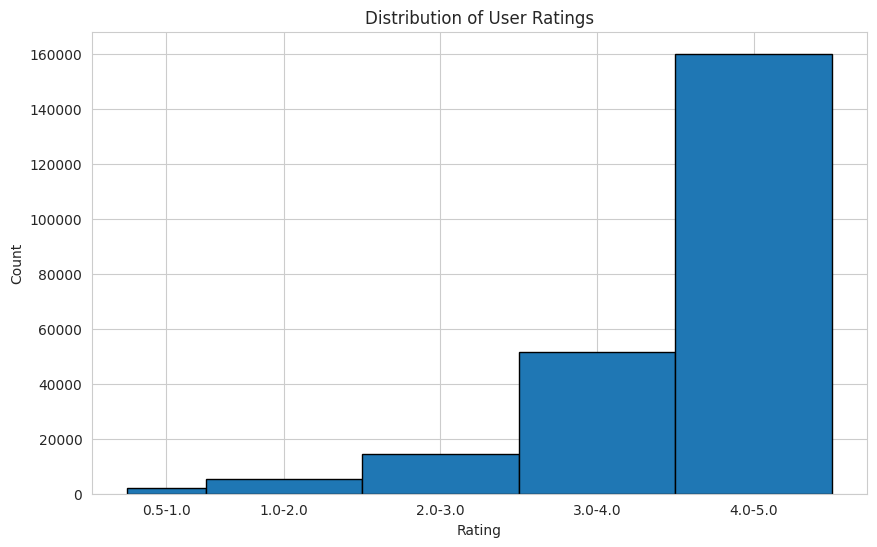

In [51]:
plt.figure(figsize=(10, 6))

# Define the bins
bins = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

# Create the histogram
plt.hist(ratings['rating'], bins=bins, edgecolor='black')

# Customize the plot
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Calculate the center of each bin
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

# Set x-axis labels to show the bin ranges, centered on each bin
plt.xticks(bin_centers, ['0.5-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0'])

plt.show()

Next we'll create a horizontal bar chart that displays the top 15 movies based on their average ratings, filtered for those with a minimum number of 100 ratings.

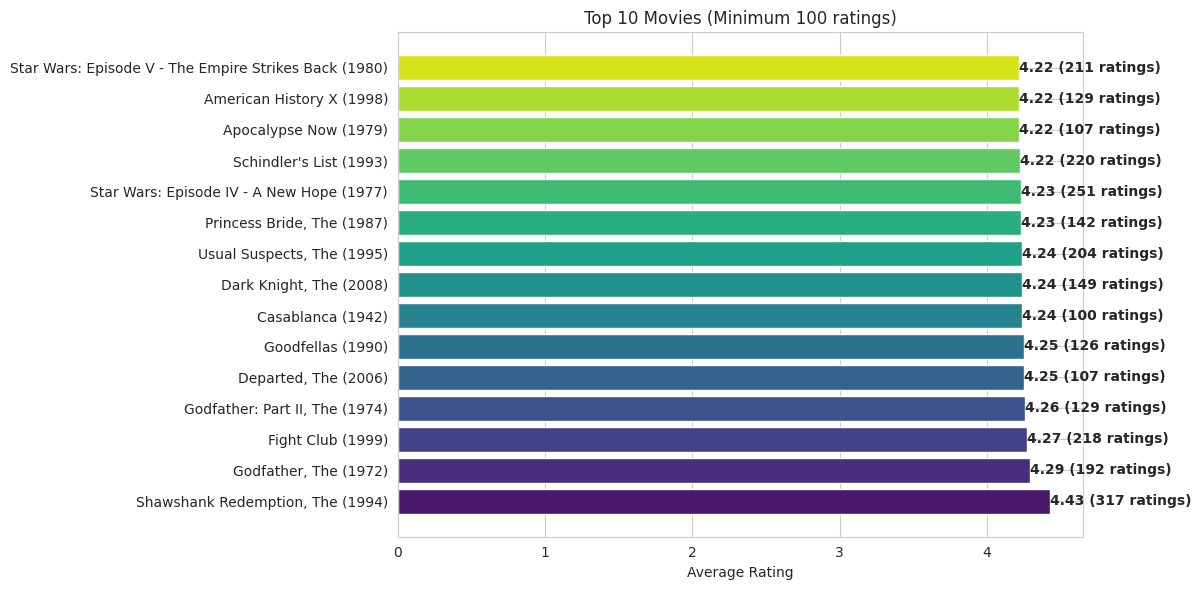


Top 10 Movies Data:
                                                title  avg_rating  num_ratings
                     Shawshank Redemption, The (1994)    4.429022          317
                                Godfather, The (1972)    4.289062          192
                                    Fight Club (1999)    4.272936          218
                       Godfather: Part II, The (1974)    4.259690          129
                                 Departed, The (2006)    4.252336          107
                                    Goodfellas (1990)    4.250000          126
                                    Casablanca (1942)    4.240000          100
                              Dark Knight, The (2008)    4.238255          149
                           Usual Suspects, The (1995)    4.237745          204
                           Princess Bride, The (1987)    4.232394          142
            Star Wars: Episode IV - A New Hope (1977)    4.231076          251
                              S

In [55]:
# Calculate average rating for each movie and number of ratings
movie_stats = ratings_with_titles.groupby('title').agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten the column names
movie_stats.columns = ['title', 'avg_rating', 'num_ratings']

# Filter for movies with a minimum number of ratings
min_ratings = 100
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]

# Sort by average rating and get top 10
top_movies = popular_movies.sort_values('avg_rating', ascending=False).head(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_movies)), width=top_movies['avg_rating'],
                color=sns.color_palette("viridis", len(top_movies)))

# Customize the plot
plt.yticks(range(len(top_movies)), top_movies['title'])
plt.xlabel('Average Rating')
plt.title(f'Top 10 Movies (Minimum {min_ratings} ratings)')

# Add rating annotations to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{top_movies["avg_rating"].iloc[i]:.2f} ({top_movies["num_ratings"].iloc[i]} ratings)',
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Movies Data:")
print(top_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))

In [52]:
counts, _ = np.histogram(ratings['rating'], bins=bins)
for i, count in enumerate(counts):
    print(f"Bin {bins[i]}-{bins[i+1]}: {count}")

Bin 0.5-1.0: 1908
Bin 1.0-2.0: 5289
Bin 2.0-3.0: 14443
Bin 3.0-4.0: 51445
Bin 4.0-5.0: 160128


I then check for duplicates. There are none.

In [5]:
# check for duplicates
ratings.duplicated().sum()

0

In [6]:
# check data types
ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


In [7]:
# Drop the timestamp column
ratings.drop('timestamp', axis=1, inplace=True)

Now, I'll add the `title` column from the `movies` dataframe to the `ratings` dataframe based on the common `movieId` column.

In [8]:
# extracting the title from the `movies` df based on the `movieId`
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')

I'm starting with the `ratings_with_titles` df for my basic recommendation model because it contains key user-item interactions, which are essential for collaborative filtering. This dataframe shows which users rated which movies and their ratings, allowing me to identify patterns in preferences.

I'll use collaborative filtering, focusing on either:

- User-Based: Recommending movies based on the preferences of similar users.
- Item-Based: Suggesting movies based on similarities between items that users have liked.

Using `ratings_with_titles` gives me a solid foundation for identifying these relationships, and I can later integrate `movies` and `tags` dataframes for more nuanced recommendations.

Now, I'll create a scikit surprise dataset from the `ratings` dataframe.

In [9]:
# reading the values as scikit surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

In [10]:
# parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

In [11]:
# create the grid search object
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=5, n_jobs=-1)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   57.4s finished


In [12]:
# Get the best parameters
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8835658808016412, 'mae': 0.6825949508641015}
{'rmse': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}}


In [13]:
# Cross validation with KNNBasic
# Parameter grid for KNNBasic
param_grid = {
    'k': [20, 40, 60],
    'min_k': [1, 2, 3],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson'],
        'user_based': [True, False]
    }
}

# Create the grid search object
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the data
gs.fit(data)

# Get the best parameters and scores
print("Best RMSE:", gs.best_score['rmse'])
print("Best MAE:", gs.best_score['mae'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE: 0.9125352416081686
Best MAE: 0.7021024880661285
Best Parameters: {'k': 60, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
# These 2 code cells run faster than the cell above

# Cross validation with KNNBasic
# knn_basic = KNNBasic(sim_options={'name':'msd', 'user_based':True})
# cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

# and this
# Average RMSE
# for i in cv_knn_basic.items():
#     print(i)
# print('-----------------------')
# print(np.mean(cv_knn_basic['test_rmse']))

In [14]:
knn_baseline = KNNBaseline(sim_options={'name':'msd', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [15]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87406732, 0.88135279, 0.8728846 , 0.87116977, 0.87255197]))
('test_mae', array([0.66660386, 0.67465064, 0.66872485, 0.66397223, 0.66660341]))
('fit_time', (0.4577674865722656, 0.45226287841796875, 0.481304407119751, 0.4475846290588379, 0.5270798206329346))
('test_time', (1.7249116897583008, 1.5894012451171875, 1.563307523727417, 1.5415713787078857, 3.6548044681549072))


0.8744052902032695

Based off these outputs, it seems like the best performing model is the SVD model with n_factors = 100 and a regularization rate of 0.4.

Next, I'll create a `get_movie_recommendations` function that is designed to enhance the user experience by allowing users to provide ratings for a selection of movies they've seen. It prompts users to rate five randomly chosen movies on a scale of 0.5 to 5. If a user hasn't watched a particular movie, they can simply enter 'n' to skip it.

After collecting the ratings, the function uses a trained recommendation model to predict ratings for all movies in the dataset. It then adjusts the predicted ratings based on the user's inputs and recommends the top movies tailored to their preferences. This approach ensures that users receive personalized suggestions that align with their tastes.

In [16]:
def get_movie_recommendations(user_id, ratings_with_titles, model, n_recommendations=5):
    # Prepare a sample of movies to prompt the user
    sample_movies = ratings_with_titles.sample(n=5)
    print("Please rate the following movies on a scale of 0.5 to 5 (or enter 'n' to skip):")

    user_ratings = {}

    for index, row in sample_movies.iterrows():
        title = row['title']
        # Prompt user for rating
        rating_input = input(f"Rate '{title}': ")

        if rating_input.lower() == 'n':
            continue  # Skip this movie if the user hasn't seen it

        try:
            rating = float(rating_input)
            user_ratings[row['movieId']] = rating
        except ValueError:
            print("Invalid input. Please enter a number between 0.5 and 5 or 'n' to skip.")

    # Get predictions for all movies
    all_movie_ids = ratings_with_titles['movieId'].unique()
    predictions = []

    for movie_id in all_movie_ids:
        # Use the model to predict the rating
        pred_rating = model.predict(user_id, movie_id).est

        # If the user rated this movie, adjust the prediction based on their rating
        if movie_id in user_ratings:
            adjusted_rating = (pred_rating + user_ratings[movie_id]) / 2
        else:
            adjusted_rating = pred_rating

        predictions.append((movie_id, adjusted_rating))

    # Sort predictions by adjusted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Recommend top N movies
    recommended_movies = predictions[:n_recommendations]

    # Convert movie IDs to titles
    recommended_titles = ratings_with_titles[ratings_with_titles['movieId'].isin([m[0] for m in recommended_movies])]

    return recommended_titles[['title', 'movieId']]

# Usage
user_id = 55  # user ID
best_model = gs.best_estimator['rmse']  # or 'mae'
best_model.fit(trainset)
recommended_movies = get_movie_recommendations(user_id, ratings_with_titles, best_model)
print("Recommended Movies:")
print(recommended_movies)

Computing the msd similarity matrix...
Done computing similarity matrix.
Please rate the following movies on a scale of 0.5 to 5 (or enter 'n' to skip):
Rate 'Enemy of the State (1998)': 3.8
Rate 'Babes in Toyland (1934)': 3.9
Rate 'Tall Guy, The (1989)': 4.0
Rate 'Treasure Island (2012)': 4.3
Rate 'Mexican, The (2001)': 3.5
Recommended Movies:
                      title  movieId
9016   Way Back, The (2010)    83369
9139       The Mummy (2017)   170827
9147           Black Mirror   176601
9153           Alpha (2018)   185031
90034            61* (2001)    27373


## Neural Networks

To prepare to build a neural network, I'll merge `movies`, `ratings` and `tags` dataframes to one dataframe. First, I'll merge `movies` and `ratings`.

In [17]:
movies_ratings = pd.merge(movies, ratings, on='movieId', how='left')

Then, we'll merge the results with `tags` dataframe.

In [18]:
movies_ratings_tags = pd.merge(movies_ratings, tags, on='movieId', how='left')

Since two userId columns(userId_x, userId_y) have been created after the merge, we'll drop one userId column.

In [19]:
movies_ratings_tags = movies_ratings_tags.drop('userId_y', axis=1)
movies_ratings_tags = movies_ratings_tags.rename(columns={'userId_x': 'userId'})

Next, we'll drop the `timestamp` column:

In [20]:
movies_ratings_tags = movies_ratings_tags.drop('timestamp', axis=1)

I got performance issues for my neural network model, so I'll be dropping any rows where any column has a null value.

In [21]:
# Drop any rows with null values in any column
movies_ratings_tags = movies_ratings_tags.dropna()

### Step 1: Data Preparation

First, we'll preprocess the data to create user-item pairs suitable for training our model.

In [22]:
# Importing libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

In [23]:
# Create user-item interaction matrix
ratings = movies_ratings_tags[['userId', 'movieId', 'rating']]

In [24]:
# Create user and movie mappings
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

In [25]:
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

In [26]:
# Convert userId and movieId to indices
ratings['userIndex'] = ratings['userId'].map(user_to_index)
ratings['movieIndex'] = ratings['movieId'].map(movie_to_index)

In [27]:
# Split the data into training and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

X_train = train[['userIndex', 'movieIndex']]
y_train = train['rating']
X_test = test[['userIndex', 'movieIndex']]
y_test = test['rating']

### Step 2: Build the Neural Network

Now we can create a simple neural network that learns from user-item interactions.

In [28]:
# Define model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 50  # Size of the embedding vectors

In [29]:
# Define the model architecture
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

In [30]:
# Flatten the embeddings
user_vecs = Flatten()(user_embedding)
movie_vecs = Flatten()(movie_embedding)

In [31]:
# Compute the dot product of user and movie vectors
dot_product = Dot(axes=1)([user_vecs, movie_vecs])

In [32]:
# Add a Dense layer for more learning capacity
output = Dense(1, activation='linear')(dot_product)

In [33]:
# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │         30,500 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │         77,700 │ movie_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │              2 │ dot[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 108,202 (422.66 KB)

 Trainable params: 108,202 (422.66 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Train the Model

Now, we'll train the model on the training data.

In [35]:
# Train the model
model.fit([X_train['userIndex'], X_train['movieIndex']], y_train, epochs=10, batch_size=64, validation_data=([X_test['userIndex'], X_test['movieIndex']], y_test))

Epoch 1/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0196 - val_loss: 0.1307
Epoch 2/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0177 - val_loss: 0.1315
Epoch 3/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0158 - val_loss: 0.1314
Epoch 4/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0146 - val_loss: 0.1339
Epoch 5/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0136 - val_loss: 0.1329
Epoch 6/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0125 - val_loss: 0.1341
Epoch 7/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0117 - val_loss: 0.1345
Epoch 8/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0110 - val_loss: 0.1356
Epoch 9/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0105 - val_loss: 0.1360
Epoch 10/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0097 - val_loss: 0.1379


In [36]:
print("Training Data NaNs:", X_train.isnull().sum().sum(), y_train.isnull().sum())

Training Data NaNs: 0 0


### Step 4: Making Recommendations

After training, we'll create a function to generate movie recommendations for a specific user based on their ratings.

In [41]:
def get_movie_recommendations(user_id, ratings_with_titles, model, n_recommendations=5):
    # Get the user's index
    user_index = user_to_index[user_id]

    # Get all movie indices
    all_movie_indices = np.arange(len(movie_ids))

    # Predict ratings for all movies
    predictions = model.predict([np.full_like(all_movie_indices, user_index), all_movie_indices])
    predictions = np.clip(predictions, 0, 5)
    print("Predictions:", predictions)  # Check the predictions for NaN values

    # Create a DataFrame for the predictions
    pred_df = pd.DataFrame({
        'movieIndex': all_movie_indices,
        'predicted_rating': predictions.flatten()
    })

    # Create a mapping of movieIndex to movieId
    movie_index_to_id = {idx: movie_id for movie_id, idx in movie_to_index.items()}
    pred_df['movieId'] = pred_df['movieIndex'].map(movie_index_to_id)

    # Merge with the original ratings to get movie titles
    recommended_movies = pred_df.merge(movies_ratings_tags[['movieId', 'title']].drop_duplicates(), on='movieId', how='left')

    # Sort by predicted rating and get the top N recommendations
    top_recommendations = recommended_movies.sort_values(by='predicted_rating', ascending=False).head(n_recommendations)

    return top_recommendations[['title', 'predicted_rating']]

# Usage
user_id = 55  # user ID
recommended_movies = get_movie_recommendations(user_id, movies_ratings_tags, model)
print("Recommended Movies:")
print(recommended_movies)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predictions: [[3.21274  ]
 [3.5196304]
 [2.2874794]
 ...
 [3.2781982]
 [2.8412297]
 [2.552798 ]]
Recommended Movies:
                        title  predicted_rating
1457  Django Unchained (2012)          5.000000
101          True Lies (1994)          5.000000
1410                Up (2009)          4.962708
1298             Crash (2004)          4.950359
858              K-PAX (2001)          4.937927
